In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as spla
# import tensorflow as tf
import torch
import torchvision
import torchvision.datasets as datasets
from torchvision import transforms 
from torch.utils.data import DataLoader
from collections import OrderedDict
from tqdm import tqdm
from numpy.polynomial.chebyshev import chebval
from ml_collections import config_dict
import scipy.sparse as sparse
import os, sys

root_dir = r'/workspace/ydong/RandNLA' 

font = {'weight' : 'bold',
        'size'   : 12}
legend = {'fontsize': 16}
lines = {'linewidth':3, 'markersize':9}
plt.rc('font', **font) 
plt.rc('legend', **legend)
plt.rc('lines', **lines)

markers = ['o','^','s','p','d']
colors = ['b','g','r','c','m','y']

# Utils

In [2]:
def power_iteration(A,Omega,p, krylov=False):
    '''
    A: ndarray(shape=(m,n))
    Omega: ndarray(shape=(n,l))
    p: non-negative int
    Acol: ndarray(shape=(m,l)), ((A@A.T)**p)@A@Omega with orthonormalization
    '''
    l = Omega.shape[-1]
    X = A@Omega #(m,l)
    Qcol,_ = spla.qr(X, mode='economic') #(m,l)
    for iter in range(p):
        if krylov:
            Qrow,_ = spla.qr(A.T@Qcol, mode='economic') #(n,l*(iter+1))
            Qcol,_ = spla.qr(A @ np.hstack((Qrow,Omega)),mode='economic') #(m,l*(iter+2))
        else:
            Qrow,_ = spla.qr(A.T@Qcol[:,-l:], mode='economic') #(n,l)
            Qcol,_ = spla.qr(A@Qrow,mode='economic') #(m,l)
    return Qcol.astype(np.double)


def rsvd(A, k, l=None, power_iter=0, algo='rsvd', return_Omega=0, 
         embedding=lambda d,l: np.random.randn(d,l)/np.sqrt(l)):
    '''
    * algo: 'rsvd'(default, Halko2011), 'gn'(generalized Nystrom), 'bk'(block Krylov)
    * return_Omega: 0 = not return, 1 = return embedding, 2 = return embedding + distribution
    '''
    if l is None:
        l = min(k+10, A.shape[1])

    # construct low-rank approximation
    if algo=='bk': # block krylov (ignoring l)
        Omega = embedding(A.shape[1],l).astype(np.double) #(n,l)
        Qcol = power_iteration(A,Omega,power_iter,krylov=True) #(m,l*(p+1))
        Uap_reduced, sap, Vhap = spla.svd(Qcol.T @ A, full_matrices=False, lapack_driver='gesvd') #(l*(p+1),l*(p+1)),(l*(p+1),),(l*(p+1),n)
        Uap = Qcol @ Uap_reduced #(m,l*(p+1))
    elif algo=='gn': # generalized Nystrom
        l_large = np.ceil(1.5*k)
        Omega = embedding(A.shape[1],l).astype(np.double) #(n,l)
        Gamma = embedding(A.shape[0],l_large).astype(np.double) #(m,l_large)
        Qcol = power_iteration(A,Omega,power_iter) #(m,l)
        Qrow = power_iteration(A.T,Gamma,0) #(n,l_large)
        core = (Qcol.T @ A) @ Qrow #(l,l_large)
        Uap_reduced, sap, Vhap_reduced = spla.svd(core, full_matrices=False, lapack_driver='gesvd') #(l,l),(l,),(l,l_large)
        Uap = Qcol @ Uap_reduced #(m,l)
        Vhap = Vhap_reduced @ Qrow.T #(l,n)
    else: # rsvd
        Omega = embedding(A.shape[1],l).astype(np.double) #(n,l)
        Qcol = power_iteration(A,Omega,power_iter) #(m,l)
        Uap_reduced, sap, Vhap = spla.svd(Qcol.T @ A, full_matrices=False, lapack_driver='gesvd') #(l,l),(l,),(l,n)
        Uap = Qcol @ Uap_reduced #(m,l)
    
    # output
    if return_Omega==1:
        return Uap, sap, Vhap, Omega
    elif return_Omega==2:
        return Uap, sap, Vhap, Omega, embedding
    else:
        return Uap, sap, Vhap


def lupp(A):
    '''
    A of size mxk with rank k and m >= k
    
    A[p,:] = L@U
    p: ndarray(shape=(m,), dtype=int)
    L: ndarray(shape=(m,k), dtype=float)
    U: ndarray(shape=(k,k), dtype=float)
    '''
    P, L, U = spla.lu(A)
    p = (P.T @ np.arange(A.shape[0]).reshape(-1,1)).astype(int).reshape(-1)
    return L, U, p


def cpqr(A):
    '''
    A of size kxn with rank k and n >= k
    
    A[:,p] = Q@R
    p: ndarray(shape=(n,), dtype=int)
    Q: ndarray(shape=(k,k), dtype=float)
    R: ndarray(shape=(k,n), dtype=float)
    '''
    Q,R,p = spla.qr(A, mode='economic', pivoting=True)
    return Q, R, p.astype(int)


def stable_id_error(A, row_idx, return_approx=False, ord='fro'):
    R = A[row_idx,:] #(k,n)
    Qr, _ = spla.qr(R.T, mode='economic') #(n,k)
    A_sid = (A @ Qr) @ Qr.T 
    error = spla.norm(A - A_sid, ord=ord)
    if return_approx:
        return error, A_sid
    else:
        return error


def matdivide(A,B, compute_spectrum=False, tol=1e-16):
    '''
    A: (m,n) ndarray
    B: (k,n) ndarray
    compute A*pinv(B), or its spectrum
    '''
    U,s,Vh = spla.svd(B, full_matrices=False, lapack_driver='gesvd')
    r = np.count_nonzero(s>tol)
    Aux = (A @ Vh[:r].T)/s[:r].reshape(1,-1) #(m,r)
    if compute_spectrum:
        spectrum = spla.svd(Aux, compute_uv=False, lapack_driver='gesvd')
        return spectrum
    else:
        return (Aux @ U[:,:r].T) #(m,k)


def canonical_angles(U,V, check_ortho=True, tol=1e-16):
    '''
    Input
    -----
    * U: ndarray(shape=(d,k)) (d>k)
    * V: ndarray(shape=(d,l)) (d>l)
    Output
    ------
    * min(k,l) sin's and cos's, descending
    '''
    U = U.astype(np.longdouble)
    V = V.astype(np.longdouble)
    if check_ortho:
        U,_ = spla.qr(U, mode='economic')
        V,_ = spla.qr(V, mode='economic')
    Mcos = U.T @ V # (k,l)
    cos = spla.svd(Mcos, full_matrices=False, compute_uv=False, lapack_driver='gesvd')
    if cos[0]>=1. or cos[-1]<tol: # compute sin instead for highly overlapped (U,V)
        if U.shape[-1]>V.shape[-1]: #k>l
            Msin = V - U @ Mcos #(d,l)
        else: #l>=k
            Msin = U - V @ Mcos.T #(d,k)
        sin = spla.svd(Msin, full_matrices=False, compute_uv=False, lapack_driver='gesvd')
        return np.flip(sin)
    else:
        return np.sqrt(1.-cos**2)

# Target matrices

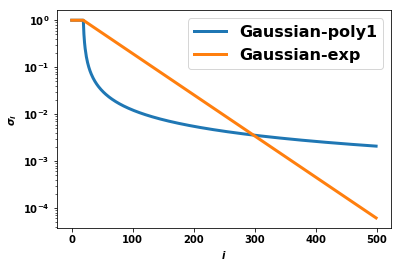

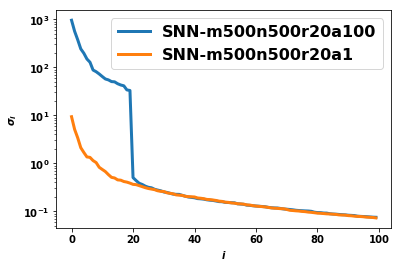

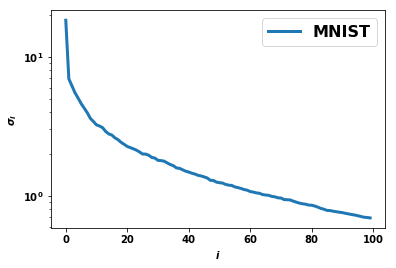

odict_keys(['Gaussian-poly1', 'Gaussian-exp', 'SNN-m500n500r20a100', 'SNN-m500n500r20a1', 'MNIST'])


In [3]:
def genenrate_mnist_target(size=800):
    '''
    Output
    -----
    * target: dict('A':ndarray(shape=(m,n)), 
                   'U':ndarray(shape=(m,r)), 
                   's':ndarray(shape=(r,)), 
                   'V':ndarray(shape=(n,r)),
                   'tag':string)
    '''
    dataset = datasets.MNIST(root=os.path.join(root_dir,'dataset'), train=False, download=False, transform=transforms.ToTensor())
    dataloader = DataLoader(dataset, batch_size=size, shuffle=True)
    X,_ = next(iter(dataloader))
    X = X.view(size,-1).numpy().astype(np.double)
    X = X / spla.norm(X, ord=2, axis=1, keepdims=True)
    U,s,Vh = spla.svd(X, full_matrices=False, lapack_driver='gesvd')
    target = {'A': X.astype(np.double), 
              'U': U.astype(np.double), 
              's': s.astype(np.double),
              'V': Vh.T.astype(np.double),
              'tag': 'mnist-train%d'%(size)}
    return target


def genenrate_gaussian_target(m=1000, n=1000, rank=1000, spectrum=None):
    '''
    Output
    -----
    * target: dict('A':ndarray(shape=(m,n)), 
                   'U':ndarray(shape=(m,r)), 
                   's':ndarray(shape=(r,)), 
                   'V':ndarray(shape=(n,r)),
                   'tag':string)
    '''
    if spectrum is None:
        spectrum = np.linspace(1.0, 1e-5, num=rank)
    elif len(spectrum)<rank:
        spectrum = np.concatenate((spectrum, np.zeros(rank-len(spectrum))))
    U,_ = spla.qr(np.random.randn(m,rank), mode='economic')
    V,_ = spla.qr(np.random.randn(n,rank), mode='economic')
    target = {'A': (( U*(spectrum[:rank].reshape((1,-1))) )@V.T).astype(np.double), 
              'U': U.astype(np.double), 
              's': spectrum[:rank].astype(np.double),
              'V': V.astype(np.double),
              'tag': 'Gaussian'}
    return target


def generate_sparse_nonnegative_target(m=1000, n=1000, r1=20, amp=10., sparsity=0.05):
    r = min(m,n)
    weights = np.concatenate((amp/np.arange(1,r1+1), 1./np.arange(r1+1,r+1))) #(r,)
    X = sparse.random(m, r, density=sparsity, format='csr').toarray()
    Y = sparse.random(m, r, density=sparsity, format='csr').toarray()
    A = (X@(weights*Y))
    U,s,Vh = spla.svd(A, full_matrices=False, lapack_driver='gesvd')
    target = {'A': A.astype(np.double), 
              'U': U.astype(np.double), 
              's': s.astype(np.double),
              'V': Vh.T.astype(np.double),
              'tag': f'SNN-m{m:d}n{n:d}r{r1:d}a{amp:.0f}'}
    return target


def visualize_spec(spectra, range=100):
    plt.figure()
    for name, spec in spectra.items():
        plt.semilogy(spec[:range], label=name)
    plt.xlabel('$i$')
    plt.ylabel('$\sigma_i$')
    plt.legend()
    plt.show()


def get_targets(m=500, n=500, r1=20, verbose=False, tol=1e-5):
    spectra= {  'poly0d5': lambda r: np.concatenate((np.ones(r1), np.maximum(tol,1./(np.arange(2,r-r1+2))**.5))),
                'poly1': lambda r: np.concatenate((np.ones(r1), np.maximum(tol,1./np.arange(2,r-r1+2)))),
                'poly2': lambda r: np.concatenate((np.ones(r1), np.maximum(tol,1./(np.arange(2,r-r1+2))**2))),
                'exp': lambda r: np.concatenate((np.ones(r1), np.maximum(tol,0.98**(np.arange(1,r-r1+1))))),
              }
    targets = OrderedDict()
    # Gaussian random
    spectra_gaussian = dict()
    r = min(m,n)
    for decay in ['poly1','exp']:
        tag = f'Gaussian-{decay:s}'
        targets[tag] = genenrate_gaussian_target(m=m, n=n, rank=r, spectrum=spectra[decay](r))
        targets[tag]['tag'] = tag 
        spectra_gaussian[tag] = targets[tag]['s']
    # SNN
    spectra_snn = dict()
    for amp in [100,1]:
        tag = f'SNN-m{m:d}n{n:d}r{r1:d}a{amp:.0f}'
        targets[tag] = generate_sparse_nonnegative_target(m, n, r1, amp, sparsity=0.05)
        spectra_snn[tag] = targets[tag]['s']
    # MNIST
    N = 800
    targets['MNIST'] = genenrate_mnist_target(size=N)
    if verbose:
        visualize_spec(spectra_gaussian, range=500)
        visualize_spec(spectra_snn, range=100)
        visualize_spec({'MNIST':targets['MNIST']['s']}, range=100)

    return targets


targets = get_targets(verbose=True)
print(targets.keys())

# IRMS

In [4]:
get_sketch = lambda A, sample_size: A @ (np.random.randn(A.shape[1], sample_size)/np.sqrt(sample_size))

def get_id_error(A, ranks):
    sid_lupp_errs = []
    sid_cpqr_errs = []
    id_lupp_errs = []
    id_cpqr_errs = []
    oid_lupp_errs = []
    oid_cpqr_errs = []
    ious = []
    
    sample = get_sketch(A, ranks[-1])
    for r in ranks:
        Y = sample[:,:r]
        
        L,_,row_idx_lupp = lupp(Y)
        
        W_lupp = np.zeros_like(Y)
        W_lupp_sub = spla.solve_triangular(L[:r,:].T, L[r:,:].T).T
        W_lupp[row_idx_lupp,:] = np.vstack((np.eye(r), W_lupp_sub))
        W_lupp_ortho = matdivide(A[row_idx_lupp[r:],:], A[row_idx_lupp[:r],:])
        
        sid_lupp_errs.append(stable_id_error(A, row_idx_lupp[:r]))
        id_lupp_errs.append(spla.norm(A - W_lupp @ A[row_idx_lupp[:r],:], ord='fro'))
        oid_lupp_errs.append(spla.norm(A[row_idx_lupp[r:],:] - W_lupp_ortho @ A[row_idx_lupp[:r],:], ord='fro'))
        
        _,R,row_idx_cpqr = cpqr(Y.T)
        
        W_cpqr = np.zeros_like(Y)
        W_cpqr_sub = spla.solve_triangular(R[:,:r], R[:,r:]).T
        W_cpqr[row_idx_cpqr,:] = np.vstack((np.eye(r), W_cpqr_sub))
        W_cpqr_ortho = matdivide(A[row_idx_cpqr[r:],:], A[row_idx_cpqr[:r],:])
        
        sid_cpqr_errs.append(stable_id_error(A, row_idx_cpqr[:r]))
        id_cpqr_errs.append(spla.norm(A - W_cpqr @ A[row_idx_cpqr[:r],:], ord='fro'))
        oid_cpqr_errs.append(spla.norm(A[row_idx_cpqr[r:],:] - W_cpqr_ortho @ A[row_idx_cpqr[:r],:], ord='fro'))
        
        s_lupp = set(row_idx_lupp[:r])
        s_cpqr = set(row_idx_cpqr[:r])
        iou = len(s_lupp & s_cpqr)/len(s_lupp | s_cpqr)
        ious.append(iou)
        
    return np.array(sid_lupp_errs), np.array(sid_cpqr_errs), np.array(id_lupp_errs), np.array(id_cpqr_errs), np.array(oid_lupp_errs), np.array(oid_cpqr_errs), np.array(ious)

def iterative_randomized_id(A, tol, b=10, mode='tri_solv', record_error=True, verbose=False):
    '''
    mode: 'tri_solv' / 'stable_inv' + 'ortho'
    '''
    sample = get_sketch(A, b)
    residual = sample
    skeletons = np.array([])
    candidates = np.arange(A.shape[0]).astype(int)
    W = None

    errs_est = []
    errs_id = []
    errs_sid = []

    for t in range(A.shape[0]//b):
        L, _, p_row = lupp(residual) # residual(m-bt,b), L(m-bt,b), U(b,b), p_row(m-bt,)
        
        # interpolation matrix
        W_local = np.zeros((A.shape[0], b))
        if mode.find('ortho')==-1:
            if mode.find('stable_inv')!=-1:
                W_sub = matdivide(L[b:,:], L[:b,:])
            elif mode.find('tri_solv')!=-1:
                W_sub = spla.solve_triangular(L[:b,:].T, L[b:,:].T).T
            else:
                W_sub = spla.solve_triangular(L[:b,:].T, L[b:,:].T).T
            W_local[candidates[p_row],:] = np.vstack((np.eye(b), W_sub))
        else:
            W_sub = matdivide(residual[p_row[b:],:], residual[p_row[:b],:])
            W_local[candidates[p_row],:] = np.vstack((np.eye(b), W_sub))
        W = W_local if W is None else np.hstack((W, W_local)) 
                
        # skeleton indices
        skeletons = np.concatenate((skeletons, candidates[p_row[:b]])).astype(int)
        candidates = candidates[p_row[b:]].astype(int)
        
        sample = get_sketch(A, b)
        residual = sample[candidates,:] - W[candidates,:] @ sample[skeletons,:]
        # residual = sample[candidates,:] - matdivide(A[candidates,:], A[skeletons,:]) @ sample[skeletons,:]
        
        err_est = spla.norm(residual, ord='fro')
        err_id = spla.norm(A - W @ A[skeletons,:], ord='fro')
        err_sid = stable_id_error(A, skeletons)
        
        errs_est.append(err_est)
        errs_id.append(err_id)
        errs_sid.append(err_sid)
        
        if err_est < tol:
            break
        elif verbose:
            print(f'Iteration {t:3d} | Approx rank = {len(skeletons):d} | Error estimation = {err_est:6.2e} | Stable ID error = {err_sid:6.2e}')
    
    ranks = np.arange(1,t+2)*b     
    errs_est = np.array(errs_est)
    errs_id = np.array(errs_id)
    errs_sid = np.array(errs_sid)

    if record_error:
        return W, skeletons, candidates, ranks, errs_est, errs_id, errs_sid
    else: 
        return W, skeletons, candidates
    
def compare_id_algorithms(target, mode='tri_solv'):
    A = target['A']
    tol = 1e-5 * spla.norm(A, ord='fro')

    W, skeletons, _, ranks, errs_est_irms, errs_id_irms, errs_sid_irms = iterative_randomized_id(
        A, tol, b=5, mode=mode,
    )
    errs_sid_lupp, errs_sid_cpqr, errs_id_lupp, errs_id_cpqr, errs_oid_lupp, errs_oid_cpqr, ious_lu_qr = get_id_error(A, ranks)
    
    return ranks, errs_id_irms, errs_est_irms, errs_sid_irms, errs_sid_lupp, errs_sid_cpqr, errs_id_lupp, errs_id_cpqr, errs_oid_lupp, errs_oid_cpqr, ious_lu_qr

In [5]:
ranks, errs_id_irms, errs_est_irms, errs_sid_irms, errs_sid_lupp, errs_sid_cpqr, errs_id_lupp, errs_id_cpqr, errs_oid_lupp, errs_oid_cpqr, ious_lu_qr = compare_id_algorithms(
    targets['Gaussian-poly1'], mode='tri_solve',
)

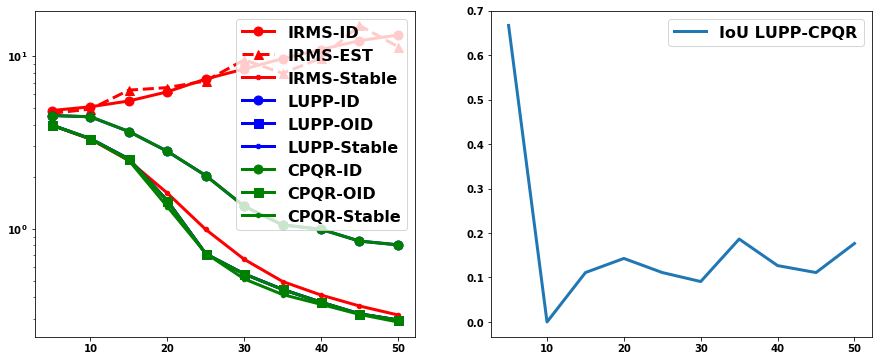

In [6]:
mask = ranks<=50
plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
plt.plot(ranks[mask], errs_id_irms[mask], 'ro-', label='IRMS-ID')
plt.plot(ranks[mask], errs_est_irms[mask], 'r^--', label='IRMS-EST')
plt.plot(ranks[mask], errs_sid_irms[mask], 'r.-', label='IRMS-Stable')

plt.plot(ranks[mask], errs_id_lupp[mask], 'bo-', label='LUPP-ID')
plt.plot(ranks[mask], errs_oid_lupp[mask], 'bs-', label='LUPP-OID')
plt.plot(ranks[mask], errs_sid_lupp[mask], 'b.-', label='LUPP-Stable')

plt.plot(ranks[mask], errs_id_lupp[mask], 'go-', label='CPQR-ID')
plt.plot(ranks[mask], errs_oid_lupp[mask], 'gs-', label='CPQR-OID')
plt.plot(ranks[mask], errs_sid_cpqr[mask], 'g.-', label='CPQR-Stable')
plt.legend()
ax = plt.gca()
ax.set_yscale('log')

plt.subplot(1,2,2)
plt.plot(ranks[mask], ious_lu_qr[mask], label='IoU LUPP-CPQR')
plt.legend()

In [15]:
ranks, errs_id_irms, errs_est_irms, errs_sid_irms, errs_sid_lupp, errs_sid_cpqr, errs_id_lupp, errs_id_cpqr, ious_lu_qr = compare_id_algorithms(
    targets['MNIST'], mode='tri_solv',
)

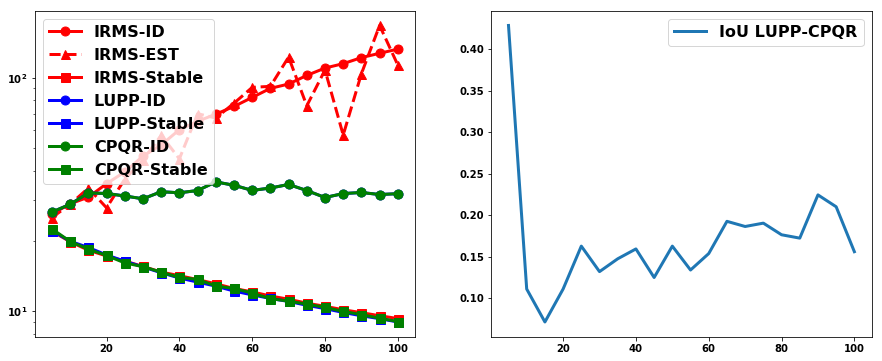

In [16]:
mask = ranks<=100
plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
plt.plot(ranks[mask], errs_id_irms[mask], 'ro-', label='IRMS-ID')
plt.plot(ranks[mask], errs_est_irms[mask], 'r^--', label='IRMS-EST')
plt.plot(ranks[mask], errs_sid_irms[mask], 'rs-', label='IRMS-Stable')

plt.plot(ranks[mask], errs_id_lupp[mask], 'bo-', label='LUPP-ID')
plt.plot(ranks[mask], errs_sid_lupp[mask], 'bs-', label='LUPP-Stable')

plt.plot(ranks[mask], errs_id_lupp[mask], 'go-', label='CPQR-ID')
plt.plot(ranks[mask], errs_sid_cpqr[mask], 'gs-', label='CPQR-Stable')
plt.legend()
ax = plt.gca()
ax.set_yscale('log')

plt.subplot(1,2,2)
plt.plot(ranks[mask], ious_lu_qr[mask], label='IoU LUPP-CPQR')
plt.legend()